In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose                         
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv(r'C:\Users\sharm\Downloads\Time-Series-Datasets-master\Time-Series-Datasets-master\monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [3]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


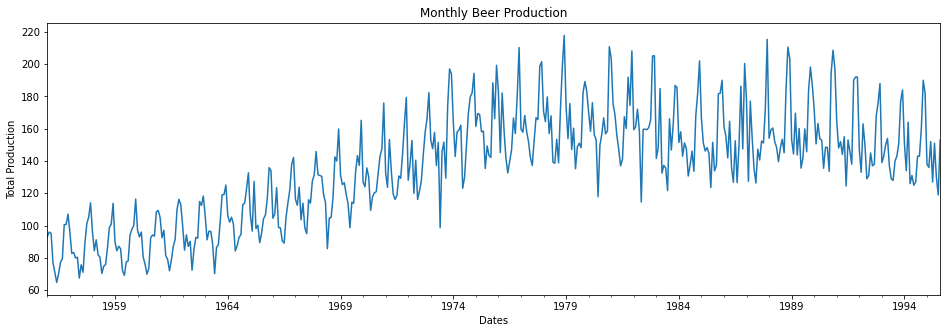

In [4]:
df.index.freq = 'MS'
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

In [5]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [8]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
452/452 [==============================] - 6s 5ms/step - loss: 0.0479
Epoch 2/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0136A: 0s - loss: 0.
Epoch 3/20
452/452 [==============================] - 3s 7ms/step - loss: 0.0124
Epoch 4/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0099
Epoch 5/20
452/452 [==============================] - 2s 5ms/step - loss: 0.0076
Epoch 6/20
452/452 [==============================] - 2s 5ms/step - loss: 0.0070
Epoch 7/20
452/452 [==============================] - 2s 5ms/step - loss: 0.0072
Epoch 8/20
452/452 [==============================] - 2s 5ms/step - loss: 0.0075
Epoch 9/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0065
Epoch 10/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0069
Epoch 11/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0077
Epoch 12/20
452/452 [==============================] - 3s 6ms/step - loss: 0.0071
Epoch 13/

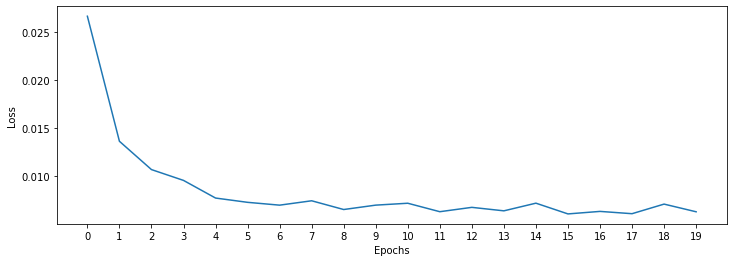

In [9]:
import matplotlib.pyplot as plt
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [10]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [11]:
lstm_predictions_scaled

[array([0.53751326], dtype=float32),
 array([0.61621255], dtype=float32),
 array([0.7365539], dtype=float32),
 array([0.7452877], dtype=float32),
 array([0.57540643], dtype=float32),
 array([0.5395134], dtype=float32),
 array([0.612451], dtype=float32),
 array([0.4659144], dtype=float32),
 array([0.46757197], dtype=float32),
 array([0.44534898], dtype=float32),
 array([0.46570057], dtype=float32),
 array([0.527022], dtype=float32)]

In [12]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[147.03952818],
       [159.08051966],
       [177.49274783],
       [178.82902061],
       [152.83718412],
       [147.3455516 ],
       [158.50500559],
       [136.08490296],
       [136.33851199],
       [132.93839364],
       [136.05218672],
       [145.43436663]])

In [13]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Monthly beer production,LSTM_Predictions
Month,,
1994-09-01,143.0,147.039528
1994-10-01,160.0,159.080520
1994-11-01,190.0,177.492748
1994-12-01,182.0,178.829021
1995-01-01,138.0,152.837184
1995-02-01,136.0,147.345552
1995-03-01,152.0,158.505006
1995-04-01,127.0,136.084903
1995-05-01,151.0,136.338512


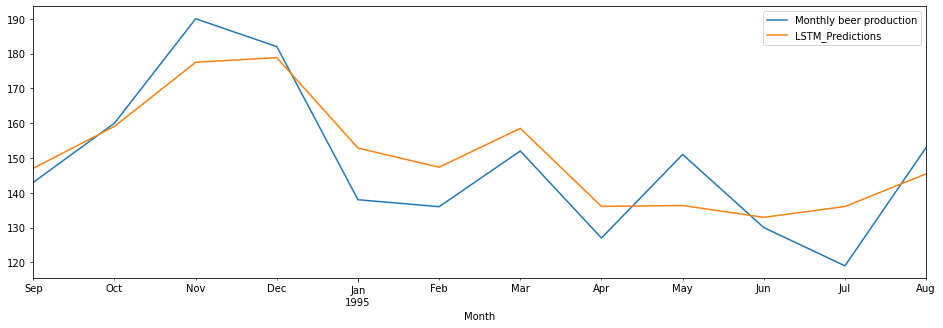

In [14]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [15]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 102.41442500819153
RMSE Error: 10.12000123558251
Mean: 136.39537815126045


In [16]:
df_pr = df.copy()
df_pr = df.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]
from fbprophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

Importing plotly failed. Interactive plots will not work.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
471,1995-04-01,151.146328,131.310157,155.653797,151.088147,151.197750,-7.956851,-7.956851,-7.956851,-7.956851,-7.956851,-7.956851,0.0,0.0,0.0,143.189478
472,1995-05-01,151.082843,127.409170,152.299206,150.999516,151.150790,-11.400291,-11.400291,-11.400291,-11.400291,-11.400291,-11.400291,0.0,0.0,0.0,139.682552
473,1995-06-01,151.017241,114.812393,138.521363,150.908689,151.104115,-23.915887,-23.915887,-23.915887,-23.915887,-23.915887,-23.915887,0.0,0.0,0.0,127.101354
474,1995-07-01,150.953756,122.105826,148.091047,150.809989,151.068015,-15.746555,-15.746555,-15.746555,-15.746555,-15.746555,-15.746555,0.0,0.0,0.0,135.207201
475,1995-08-01,150.888155,129.028945,153.746668,150.715811,151.022852,-9.208543,-9.208543,-9.208543,-9.208543,-9.208543,-9.208543,0.0,0.0,0.0,141.679612


In [17]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
1994-09-01,145.087502
1994-10-01,166.104924
1994-11-01,173.729015
1994-12-01,185.977964
1995-01-01,155.260571
1995-02-01,146.818146
1995-03-01,158.923972
1995-04-01,143.189478
1995-05-01,139.682552


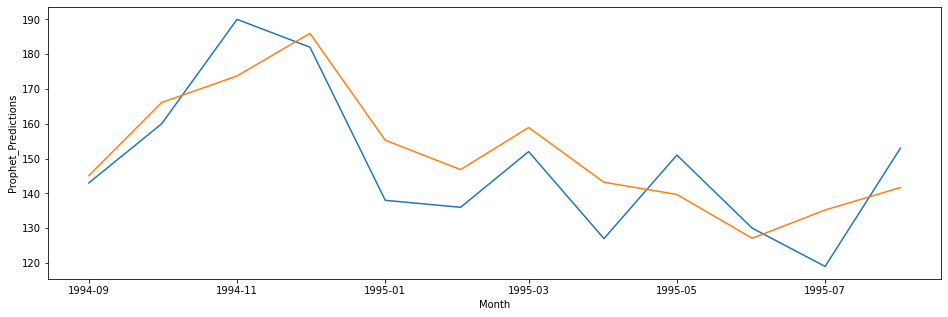

In [18]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Monthly beer production"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [19]:
prophet_rmse_error = rmse(test_data['Monthly beer production'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 131.20903532674527
RMSE Error: 11.454651252951583
Mean: 136.39537815126045


Now Ensembling both methods

In [31]:
stacking_values = []
for i in range(len(prophet_pred['Pred'])):
    stacking_values.append((prophet_pred['Pred'][i] + lstm_predictions[i]) / 2)
stacking_values


[array([146.06351496]),
 array([162.59272173]),
 array([175.61088127]),
 array([182.40349251]),
 array([154.04887737]),
 array([147.08184893]),
 array([158.71448887]),
 array([139.63719035]),
 array([138.01053205]),
 array([130.01987399]),
 array([135.62969395]),
 array([143.55698913])]

In [36]:
stacking_values = np.concatenate( stacking_values, axis=0 )

In [37]:
test_data["Ensemble_Pred"] = stacking_values
test_data

,Monthly beer production,LSTM_Predictions,Prophet_Predictions,Ensemble_Pred
Month,,,,
1994-09-01,143.0,147.039528,145.087502,146.063515
1994-10-01,160.0,159.080520,166.104924,162.592722
1994-11-01,190.0,177.492748,173.729015,175.610881
1994-12-01,182.0,178.829021,185.977964,182.403493
1995-01-01,138.0,152.837184,155.260571,154.048877
1995-02-01,136.0,147.345552,146.818146,147.081849
1995-03-01,152.0,158.505006,158.923972,158.714489
1995-04-01,127.0,136.084903,143.189478,139.637190
1995-05-01,151.0,136.338512,139.682552,138.010532


In [38]:
ensemble_rmse_error = rmse(test_data['Monthly beer production'], test_data["Ensemble_Pred"])
ensemble_mse_error = ensemble_rmse_error**2

In [39]:
rmse_errors = [ensemble_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [ensemble_mse_error, lstm_mse_error, prophet_mse_error]

In [40]:
errors = pd.DataFrame({"Models" : ["Ensemble", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
errors

,Models,RMSE Errors,MSE Errors
0,Ensemble,10.578742,111.909792
1,LSTM,10.120001,102.414425
2,Prophet,11.454651,131.209035
